In [1]:
%matplotlib inline

In [2]:
import mne
import pathlib
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt, ticker

plt.style.use("minimal.mplstyle")
mne.viz.set_browser_backend("matplotlib")

Using matplotlib as 2D backend.


In [3]:
RAW_DATA_PATH = pathlib.Path("../data/EEG")

SESSIONS = [
    "group13_a",
    "group13_b",
    "group13_c",
]

LFP_SMOOTHING = True

epochs_per_participant = [mne.read_epochs(RAW_DATA_PATH.joinpath(SESSION + ("_LPF_smoothed" if LFP_SMOOTHING else "") + "-epo.fif")) for SESSION in SESSIONS]
all_epochs = mne.concatenate_epochs(epochs_per_participant)

Reading /work/DanielAakjærLundgaard#0515/AuthorshipArtifice/analysis/../data/EEG/group13_a_LPF_smoothed-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
10988 matching events found
No baseline correction applied
0 projection items activated
Reading /work/DanielAakjærLundgaard#0515/AuthorshipArtifice/analysis/../data/EEG/group13_b_LPF_smoothed-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
6851 matching events found
No baseline correction applied
0 projection items activated
Reading /work/DanielAakjærLundgaard#0515/AuthorshipArtifice/analysis/../data/EEG/group13_c_LPF_smoothed-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
3174 matching events found
No baseline correction applied

/tmp/ipykernel_1760/247612096.py:12: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epochs_per_participant)


Not setting metadata
21013 matching events found
Applying baseline correction (mode: mean)


In [4]:
selected_contrasts = [
    {
        "Correct Trial"                 : ["correct"],
        "Incorrect Trial"               : ["incorrect"],
    },
    {
        "Positive Feedback"             : ["correct", "error rectified"],
        "Negative Feedback"             : ["incorrect", "error inserted"],
    },
    {
        "Genuine Feedback"              : ["correct", "incorrect"],
        "Manipulated Feedback"          : ["error inserted", "error rectified"],
    },
    {
        "Inserted Error"                : ["error inserted"],
        "Rectified Error"               : ["error rectified"],
    },
    {
        "Genuine Negative Feedback"     : ["incorrect"],
        "Manipulated Negative Feedback" : ["error inserted"],
    },
]

---

# Comparing evoked GFPs

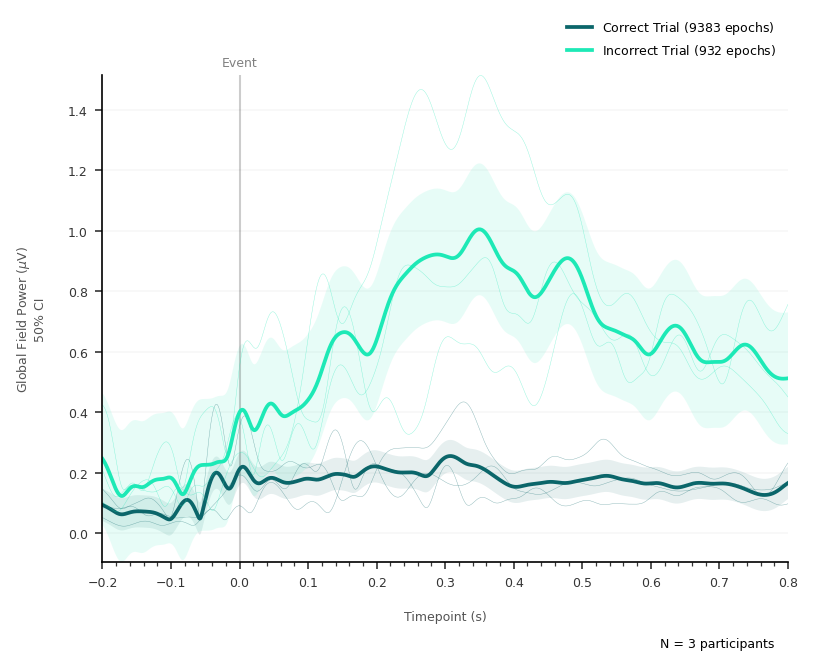

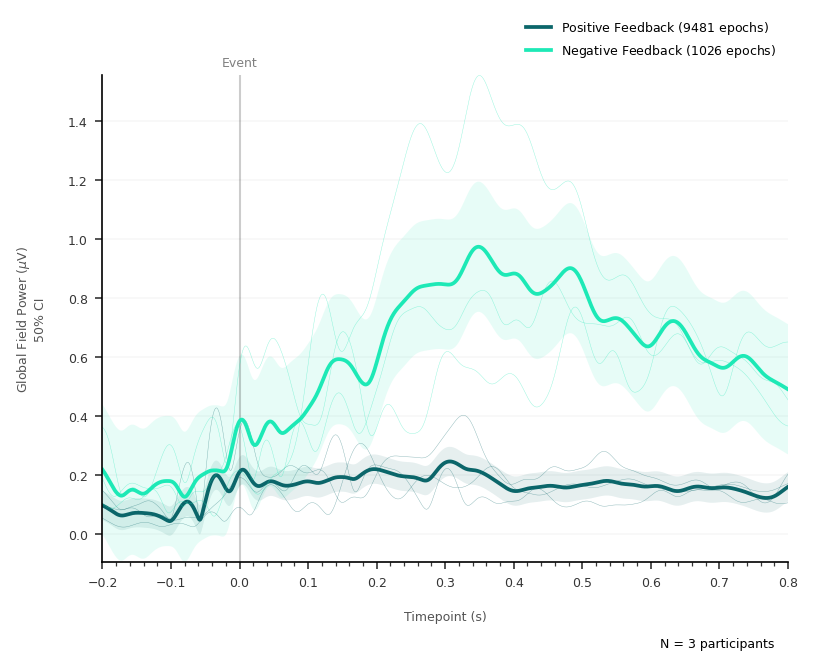

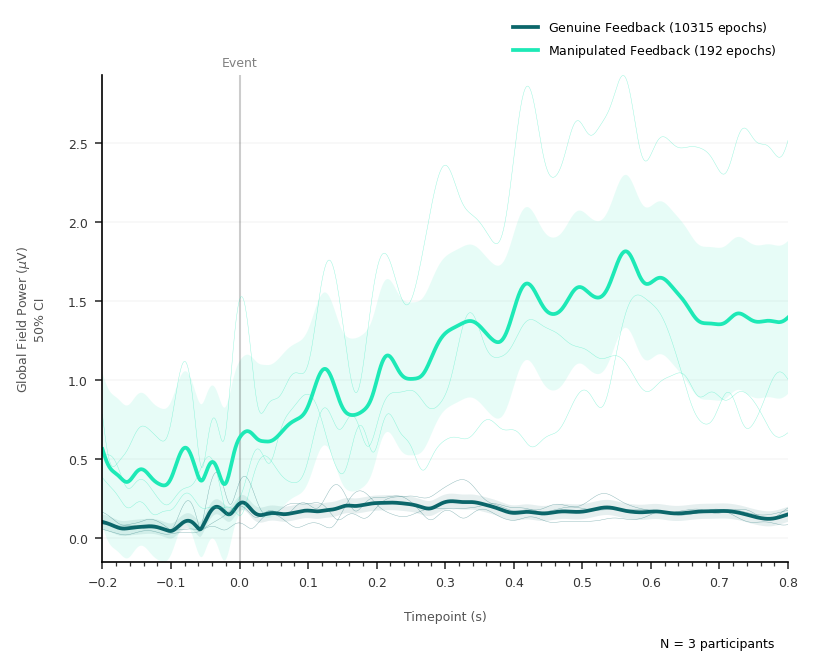

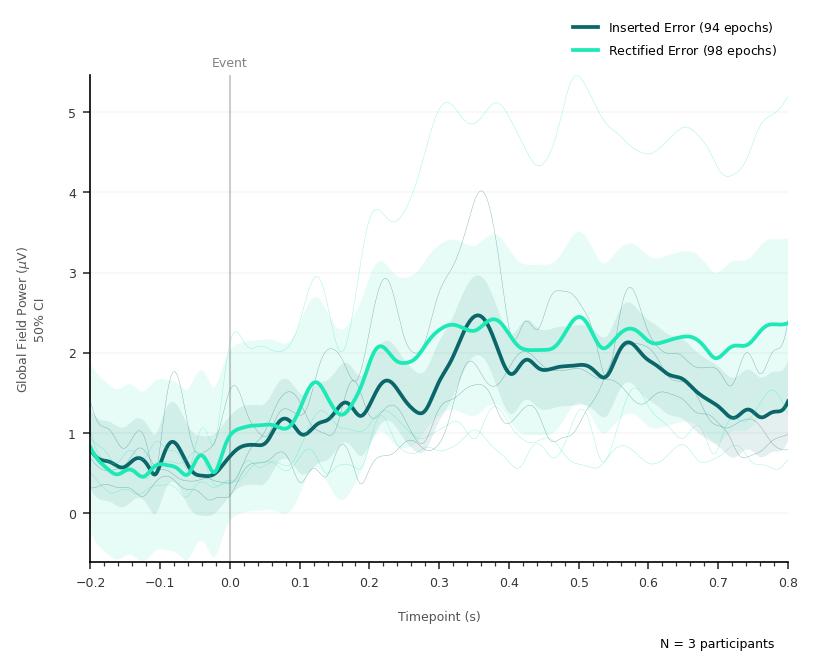

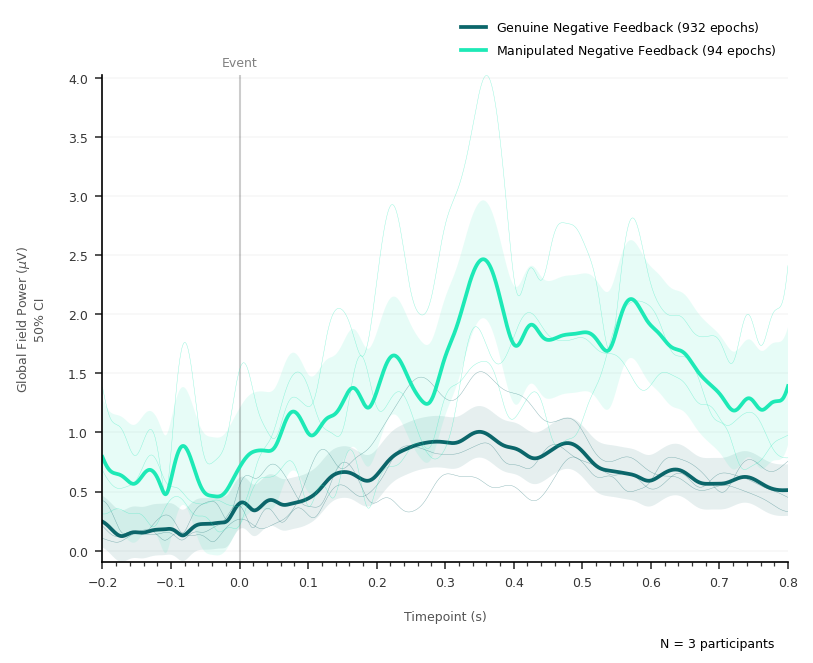

In [5]:
def compare_evoked_gfp(contrast, sensor_subset = None, ci = 0.5):
    fig, ax = plt.subplots(figsize = (5.4, 4.4))
    ax.axvline(
        x = 0, 
        color = "black",
        linewidth = 1,
        alpha = 0.2,
    )
    ax.annotate(
        "Event",
        xy = (0, 1.02),
        xycoords = ("data", "axes fraction"),
        ha = "center",
        alpha = 0.5,
    )
    ax.annotate(
        f"""N = {len(epochs_per_participant)} participant{"s" if len(epochs_per_participant) > 1 else ""}""",
        xy = (0.98, 0.02),
        xycoords = ("axes fraction", "figure fraction"),
        ha = "right",
        va = "bottom"
    )

    for condition_index, (condition_name, events_identifiers) in enumerate(contrast.items()):
        signals = np.stack([participant_epochs[events_identifiers].copy().pick(sensor_subset, exclude = "bads").average().data * 1e6 for participant_epochs in epochs_per_participant])

        for participant in signals:
            signal_magnitude = participant.std(axis = 0)
            ax.plot(
                all_epochs.times,
                signal_magnitude,
                color = f"C{condition_index}", 
                linewidth = 0.2,
                alpha = 0.5, 
            )

        signal_magnitude = signals.std(axis = 1)
        ax.plot(
            all_epochs.times,
            signal_magnitude.mean(axis = 0),
            color = f"C{condition_index}",
            linewidth = 1.8,
            label = f"{condition_name} (${len(all_epochs[events_identifiers])}$ epochs)"
        )
        ax.fill_between(
            all_epochs.times, 
            *stats.norm.interval(ci, loc=signal_magnitude.mean(axis = 0), scale = signal_magnitude.std()),
            color = f"C{condition_index}", 
            alpha=0.1,
            edgecolor = "none"
        )

    ax.legend(
        loc = "lower right", 
        bbox_to_anchor = (1, 1.01),
    )

    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
    ax.set_xlabel("Timepoint (s)")
    ax.set_ylabel(r"Global Field Power ($\mu$V)" + f"\n{ci:.0%} CI")
    ax.margins(y = 0)
    plt.tight_layout()

for contrast in selected_contrasts:
    compare_evoked_gfp(contrast)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 30


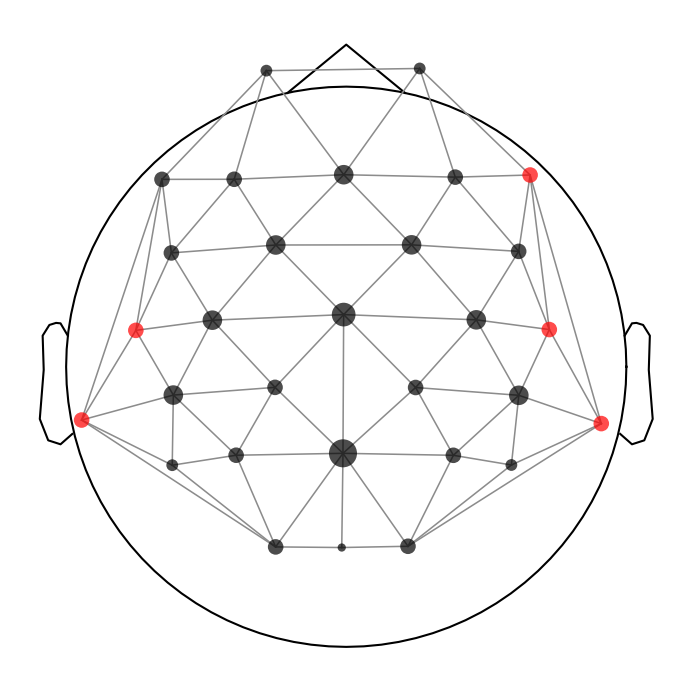

In [6]:
adjacency, ch_names = mne.channels.find_ch_adjacency(all_epochs.info, ch_type="eeg")
mne.viz.plot_ch_adjacency(all_epochs.info, adjacency, ch_names);

# Cluster-based permutation analysis

Using a threshold of 3.843186


/tmp/ipykernel_1760/1023819951.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(


stat_fun(H1): min=0.000000 max=253.281959
Running initial clustering …
Found 9 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 3.843153


/tmp/ipykernel_1760/1023819951.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(


stat_fun(H1): min=0.000000 max=277.513781
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 3.843153


/tmp/ipykernel_1760/1023819951.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(


stat_fun(H1): min=0.000000 max=59.312112
Running initial clustering …
Found 14 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 3.932438
stat_fun(H1): min=0.000000 max=20.150278
Running initial clustering …


/tmp/ipykernel_1760/1023819951.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(


Found 19 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 3.861363
stat_fun(H1): min=0.000000 max=15.493033
Running initial clustering …


/tmp/ipykernel_1760/1023819951.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(


Found 26 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

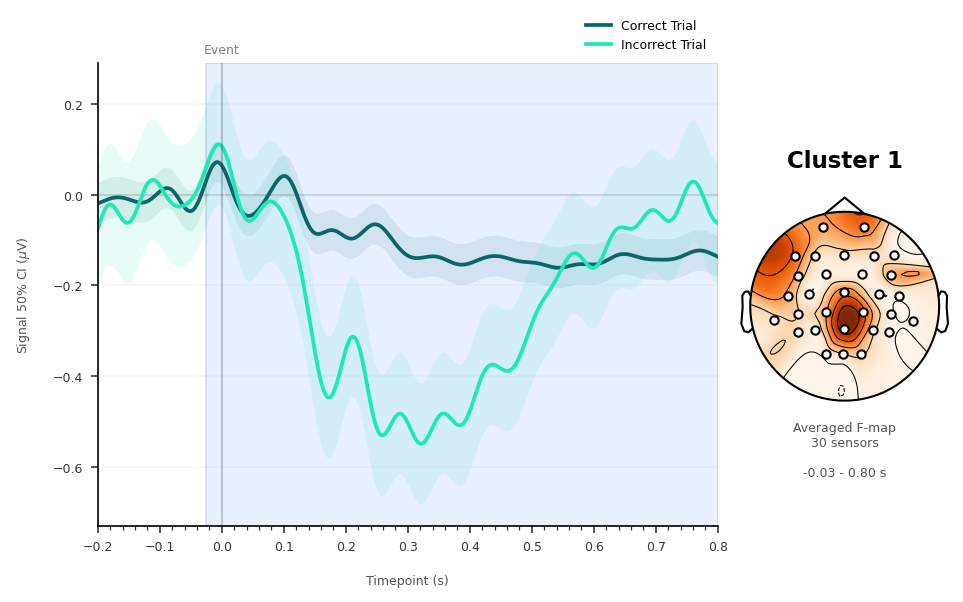

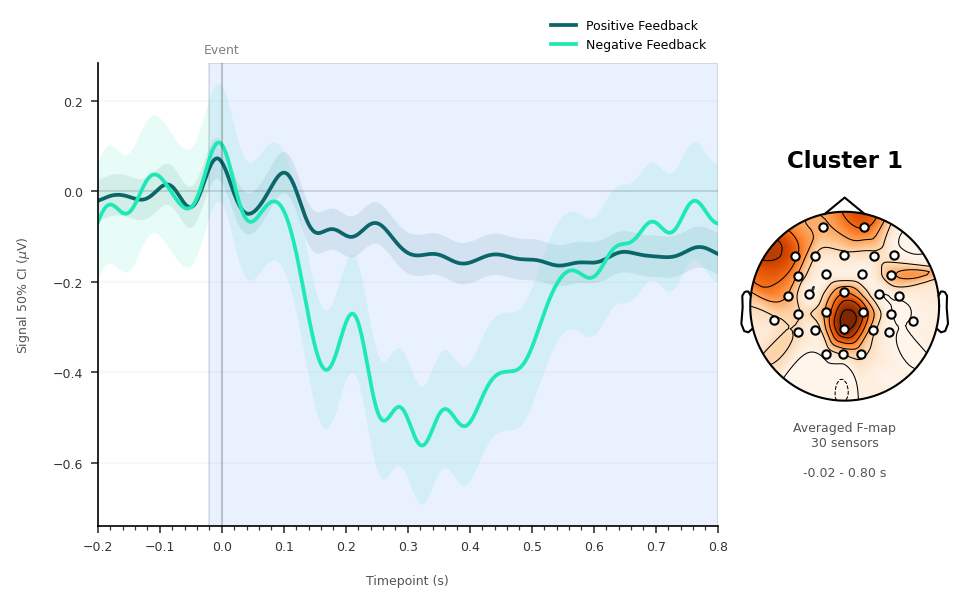

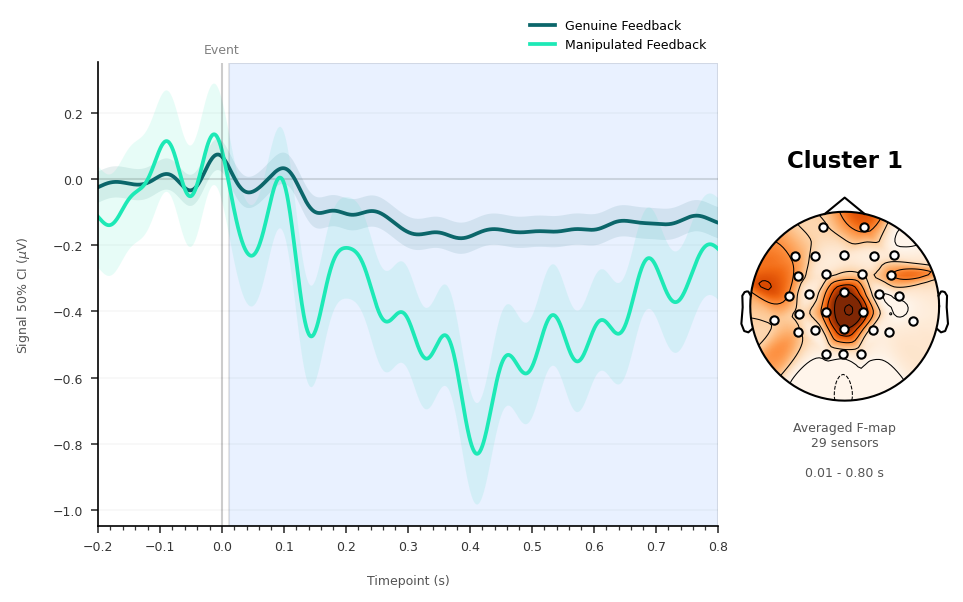

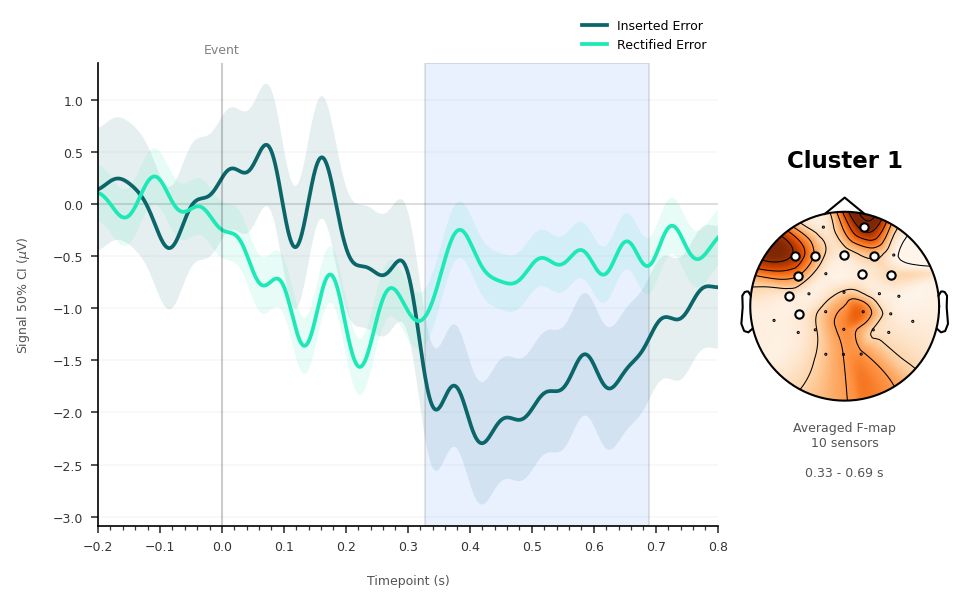

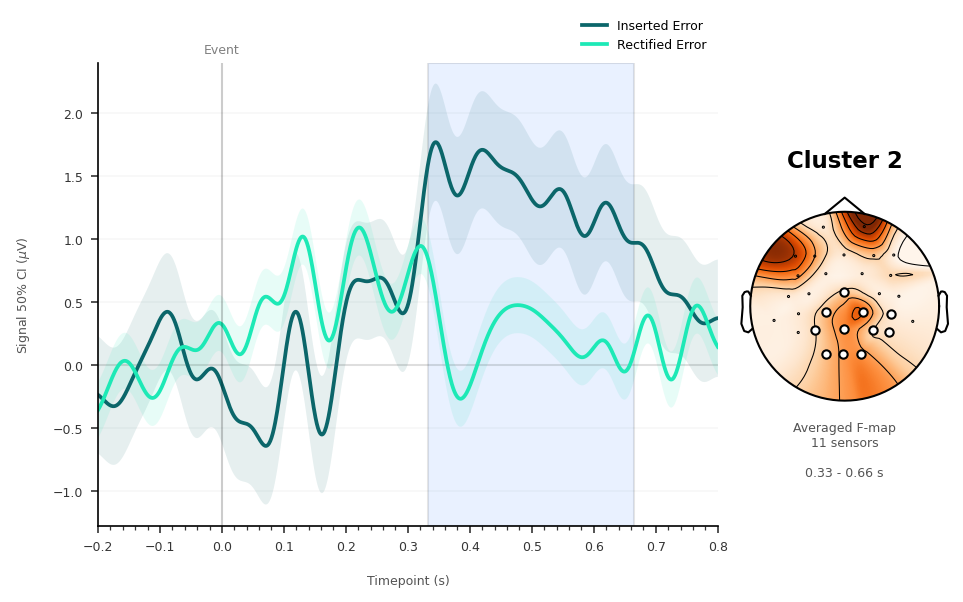

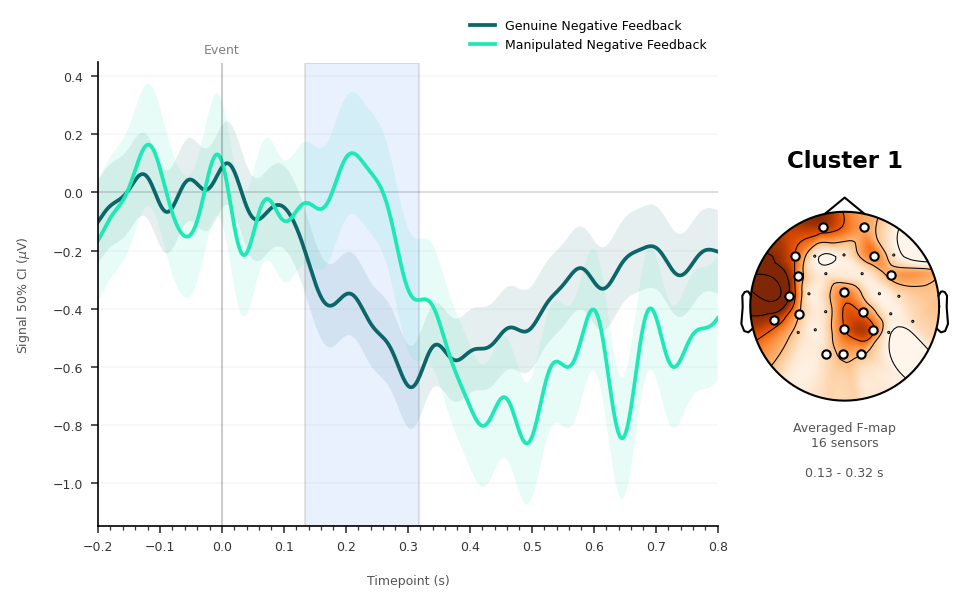

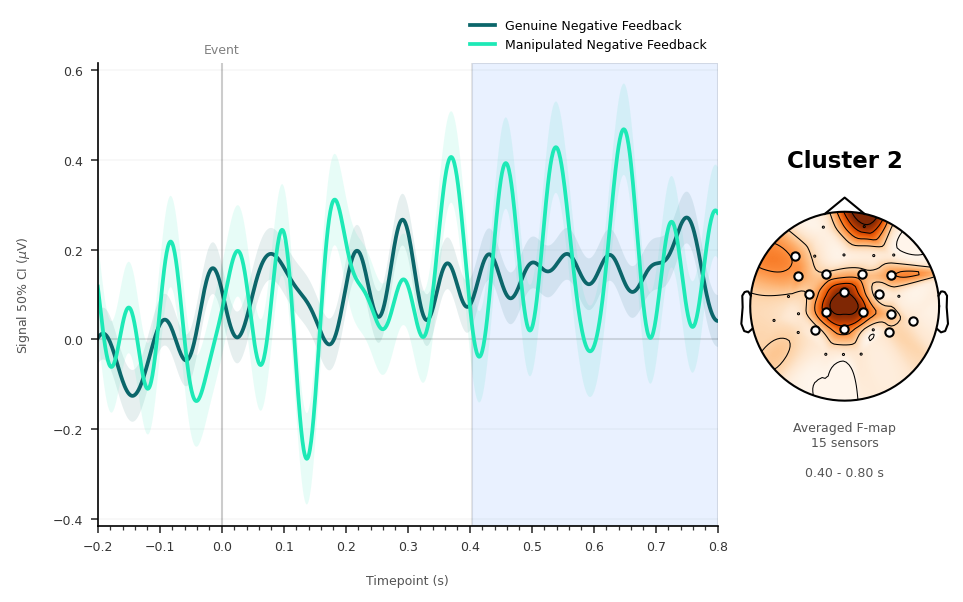

In [7]:
def perform_cluster_permutation(epochs, conditions, p_threshold = 0.05, ci = 0.5):
    def transpose_data(epochs): 
        return np.transpose(epochs.get_data(copy = True), (0, 2, 1))

    transposed_data = [transpose_data(epochs[condition]) for condition in conditions.values()]

    F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(
        X = transposed_data,
        n_permutations=1000, 
        adjacency=adjacency, 
        # seed=69,
        # n_jobs=-1, 
        n_jobs=8, 
    )

    selected_clusters = [cluster for cluster, p_val in zip(clusters, p_values) if p_val < p_threshold]
    if not len(selected_clusters):
        print("No clusters reached set significance threshold of", p_threshold)
    else:
        for cluster_id, cluster in enumerate(selected_clusters):
            time_inds, space_inds = np.squeeze(cluster)
            ch_inds = np.unique(space_inds)
            time_inds = np.unique(time_inds)

            f_map = F_obs[time_inds, ...].mean(axis=0) # topography for stats
            sig_times = epochs.times[time_inds] # signals at the sensors contributing to the cluster

            mask = np.zeros((f_map.shape[0], 1), dtype=bool) # creating spatial mask
            mask[ch_inds, :] = True

            fig, (ax_signals, ax_topography) = plt.subplots(
                ncols = 2, 
                figsize=(6.4, 4), 
                width_ratios = [0.75, 0.25], 
            )
            ax_topography.set_title(f"Cluster {cluster_id + 1}")

            mne.viz.plot_topomap(
                f_map,
                epochs.info,
                axes=ax_topography,
                cmap="Oranges",
                sphere=(0, 0, 0, 0.12),
                show=False,
                mask=mask
            )

            ax_topography.set_xlabel(f"Averaged F-map\n{len(ch_inds)} sensors\n\n{sig_times[0]:.2f} - {sig_times[-1]:.2f} s")

            ax_signals.axhline(
                y = 0, 
                color = "black",
                linewidth = 1,
                alpha = 0.1
            )
            for condition_index, (condition, cluster_signal) in enumerate(zip(conditions.keys(), transposed_data)):
                signal = cluster_signal[:, :, ch_inds].mean(axis=(0, 2)) * 1e6
                ax_signals.plot(
                    epochs.times, 
                    signal,
                    label=condition,
                    color = f"C{condition_index}",
                    linewidth = 1.8,
                )
                ax_signals.fill_between(
                    epochs.times, 
                    *stats.norm.interval(ci, loc=signal, scale = signal.std()),
                    color = f"C{condition_index}", 
                    alpha=0.1,
                    edgecolor = "none"
                )
            ax_signals.legend(loc = "lower right", bbox_to_anchor = (1, 1))
            ax_signals.set_xlabel("Timepoint (s)")
            ax_signals.set_ylabel(f"Signal {ci:.0%} CI" + " " + r"($\mu$V)")
            ax_signals.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
            ax_signals.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
            ax_signals.axvline(
                x = 0, 
                color = "black",
                linewidth = 1,
                alpha = 0.2,
            )
            ax_signals.annotate(
                "Event",
                xy = (0, 1.02),
                xycoords = ("data", "axes fraction"),
                ha = "center",
                # va = "top",
                # rotation = "vertical",
                alpha = 0.5,
            )
            
            ax_signals.axvspan(
                sig_times[0], 
                sig_times[-1], 
                facecolor="C6", 
                edgecolor="black", 
                alpha=0.1
            )

            plt.tight_layout()

for contrast in selected_contrasts:
    perform_cluster_permutation(
        epochs = epochs_per_participant[0],
        conditions = contrast,
    )